In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#
import networkx as nx
#
import sklearn
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.dummy import DummyClassifier
#
from sklearn import manifold
import gzip
from collections import OrderedDict
#
import argparse
#
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

In [2]:
def get_network_layer(G, layer=''):
    return G.subgraph([n for n, d in G.nodes(data=True) if (d.get('layer') == layer)]).copy()

In [3]:
celltype = 'spermatocyte'
network = 'thr'
threshold = 0.5
threshold_str = str(threshold).replace('.', 'p')
layer = species = 'MM'

In [4]:
# Load Network
rfnet = '../../04-network/results/network/{celltype:s}/net-{celltype:s}-{network:s}-{threshold:s}.gpickle'.format(celltype=celltype, network=network, threshold=threshold_str)
G = nx.read_gpickle(rfnet)
# layer
Gt = get_network_layer(G, layer=layer)
#

In [5]:
df = pd.DataFrame.from_dict(dict(Gt.nodes(data=True)), orient='index')

In [6]:
# Load DEG
rfdeg = '../../02-core_genes/results/DE/{species:s}-DE_genes.csv.gz'.format(celltype=celltype, species=species)
dfdeg = pd.read_csv(rfdeg, index_col=0)
#
dfdeg = dfdeg.loc[dfdeg.index.isin(df.index), :]
#
#display(dfdeg)

In [7]:
# Load FPKM
rffpkm = '../../02-core_genes/results/FPKM/{species:s}/{species:s}-FPKM-{celltype:s}.csv.gz'.format(celltype=celltype, species=species)
dffpkm = pd.read_csv(rffpkm, index_col=0)
#
dffpkm = dffpkm.loc[dffpkm.index.isin(df.index), :]
#
#display(dffpkm)

In [8]:
# Conserved
path_fpkm = '../../02-core_genes/results/FPKM/'
df_HS = pd.read_csv(path_fpkm + 'HS/HS-FPKM-{celltype:s}.csv.gz'.format(celltype=celltype), index_col='id_string')
df_MM = pd.read_csv(path_fpkm + 'MM/MM-FPKM-{celltype:s}.csv.gz'.format(celltype=celltype), index_col='id_string')
df_DM = pd.read_csv(path_fpkm + 'DM/DM-FPKM-{celltype:s}.csv.gz'.format(celltype=celltype), index_col='id_string')

dict_string_gene_HS = df_HS['id_gene'].to_dict()
dict_string_gene_MM = df_MM['id_gene'].to_dict()
dict_string_gene_DM = df_DM['id_gene'].to_dict()

path = '../../02-core_genes/results/'
dfM = pd.read_csv(path + 'meta-genes/meta-{celltype:s}-genes.csv.gz'.format(celltype=celltype), index_col='id_eggnog', usecols=['id_eggnog', 'id_string_HS', 'id_string_MM', 'id_string_DM'])

dfM['id_string_HS'] = dfM['id_string_HS'].apply(lambda x: x.split(',') if not pd.isnull(x) else [])
dfM['id_string_MM'] = dfM['id_string_MM'].apply(lambda x: x.split(',') if not pd.isnull(x) else [])
dfM['id_string_DM'] = dfM['id_string_DM'].apply(lambda x: x.split(',') if not pd.isnull(x) else [])

dfM['id_gene_HS'] = dfM['id_string_HS'].apply(lambda x: [dict_string_gene_HS[i] for i in x])
dfM['id_gene_MM'] = dfM['id_string_MM'].apply(lambda x: [dict_string_gene_MM[i] for i in x])
dfM['id_gene_DM'] = dfM['id_string_DM'].apply(lambda x: [dict_string_gene_DM[i] for i in x])

dfM = dfM[['id_gene_HS', 'id_gene_MM', 'id_gene_DM']]
# Only keep meta genes with homologs in all three species
dfM = dfM.loc[dfM.applymap(len).applymap(bool).sum(axis='columns') == 3, ['id_gene_' + layer]]
#
dict_conserved = {gene: True for gene in dfM['id_gene_' + layer].explode().tolist()}
#
df['conserved'] = df.index.map(dict_conserved)
df['conserved'].fillna(False, inplace=True)

In [9]:
# Load Core genes
rfcore = '../../02-core_genes/results/pipeline-core/{species:s}_meiotic_genes.csv'.format(species=species)
dfc = pd.read_csv(rfcore, index_col=0)
#
core_genes = dfc.index.tolist()

In [10]:
# Load PCA
rfpcad = '../../04-network/results/pca/{celltype:s}/{layer:s}/pca-{celltype:s}-{network:s}-{threshold:s}-{layer:s}-dim.csv.gz'.format(celltype=celltype, network=network, threshold=threshold_str, layer=layer)
#rfpcav = '../../04-network/results/pca/{celltype:s}/{layer:s}/pca-{celltype:s}-{network:s}-{threshold:s}-{layer:s}-s.csv.gz'.format(celltype=celltype, network=network, threshold=threshold_str, layer=layer)
dfpca = pd.read_csv(rfpcad, index_col=0)
#spcav = pd.read_csv(rfpcav, index_col=0, squeeze=True)

In [11]:
# Load Modules
rfmod = '../../05-data-analysis/entropy-based-modules/results/pca-entropy/{celltype:s}/{layer:s}/pca-{celltype:s}-{network:s}-{threshold:s}-{layer:s}-modules.csv.gz'.format(celltype=celltype, network=network, threshold=threshold_str, layer=layer)
dfmod = pd.read_csv(rfmod, index_col=0)

modcols = []
for (mid, mname), dfmodt in dfmod.groupby(['module-id', 'module-name']):
    mod_genes = dfmodt.index.tolist()
    modcol = 'module-'+str(mid)
    df[modcol] = df.index.map(lambda x: 1 if x in mod_genes else 0)
    modcols.append(modcol)

In [12]:
# Edge as column features
dfadj = nx.to_pandas_adjacency(Gt).astype(bool)
display(dfadj)

,ENSMUSG00000030314,ENSMUSG00000041477,ENSMUSG00000046718,ENSMUSG00000054619,ENSMUSG00000034947,ENSMUSG00000054966,ENSMUSG00000052363,ENSMUSG00000028842,ENSMUSG00000028420,ENSMUSG00000052917,ENSMUSG00000009941,ENSMUSG00000026436,ENSMUSG00000032547,ENSMUSG00000034848,ENSMUSG00000005610,ENSMUSG00000035560,ENSMUSG00000029502,ENSMUSG00000019794,ENSMUSG00000037013,ENSMUSG00000051579,ENSMUSG00000021548,ENSMUSG00000032959,ENSMUSG00000021182,ENSMUSG00000035242,ENSMUSG00000048602,ENSMUSG00000020955,ENSMUSG00000064358,ENSMUSG00000030965,ENSMUSG00000001844,ENSMUSG00000015942,ENSMUSG00000029199,ENSMUSG00000037725,ENSMUSG00000067365,ENSMUSG00000024983,ENSMUSG00000019864,ENSMUSG00000022336,ENSMUSG00000021758,ENSMUSG00000014550,ENSMUSG00000025348,ENSMUSG00000028557,ENSMUSG00000055041,ENSMUSG00000024668,ENSMUSG00000028312,ENSMUSG00000035211,ENSMUSG00000034312,ENSMUSG00000040913,ENSMUSG00000040367,ENSMUSG00000025497,ENSMUSG00000040714,ENSMUSG00000028108,ENSMUSG00000029723,ENSMUSG00000027881,ENSMUSG00000041809,ENSMUSG00000032555,ENSMUSG00000030327,ENSMUSG00000032279,ENSMUSG00000062949,ENSMUSG00000038831,ENSMUSG00000002324,ENSMUSG00000019437,ENSMUSG00000033530,ENSMUSG00000002984,ENSMUSG00000028041,ENSMUSG00000028642,ENSMUSG00000038975,ENSMUSG00000021364,ENSMUSG00000034194,ENSMUSG00000041565,ENSMUSG00000021961,ENSMUSG00000018599,ENSMUSG00000022235,ENSMUSG00000050002,ENSMUSG00000026174,ENSMUSG00000019942,ENSMUSG00000026094,ENSMUSG00000013539,ENSMUSG00000035212,ENSMUSG00000020376,ENSMUSG00000057842,ENSMUSG00000022184,ENSMUSG00000035420,ENSMUSG00000038500,ENSMUSG00000056153,ENSMUSG00000031527,ENSMUSG00000018923,ENSMUSG00000039813,ENSMUSG00000029314,ENSMUSG00000031958,ENSMUSG00000030867,ENSMUSG00000055692,ENSMUSG00000027677,ENSMUSG00000030224,ENSMUSG00000038930,ENSMUSG00000000295,ENSMUSG00000054021,ENSMUSG00000037020,ENSMUSG00000063077,ENSMUSG00000090173,ENSMUSG00000028520,ENSMUSG00000030691,ENSMUSG00000045259,ENSMUSG00000091956,ENSMUSG00000036644,ENSMUSG00000027613,ENSMUSG00000020705,ENSMUSG00000024552,ENSMUSG00000030555,ENSMUSG00000027067,ENSMUSG00000021144,ENSMUSG00000010608,ENSMUSG00000032355,ENSMUSG00000014353,ENSMUSG00000022771,ENSMUSG00000074212,ENSMUSG00000026698,ENSMUSG00000062939,ENSMUSG00000036943,ENSMUSG00000062382,ENSMUSG00000042705,ENSMUSG00000037818,ENSMUSG00000029310,ENSMUSG00000053550,ENSMUSG00000029028,ENSMUSG00000034601,ENSMUSG00000029581,ENSMUSG00000034892,ENSMUSG00000037958,ENSMUSG00000022800,ENSMUSG00000027569,ENSMUSG00000030754,ENSMUSG00000067338,ENSMUSG00000070803,ENSMUSG00000000440,ENSMUSG00000054836,ENSMUSG00000051728,ENSMUSG00000025465,ENSMUSG00000031788,ENSMUSG00000060802,ENSMUSG00000016833,ENSMUSG00000036036,ENSMUSG00000025288,ENSMUSG00000046719,ENSMUSG00000041138,ENSMUSG00000039754,ENSMUSG00000049299,ENSMUSG00000049526,ENSMUSG00000029146,ENSMUSG00000009628,ENSMUSG00000048668,ENSMUSG00000026966,ENSMUSG00000045031,ENSMUSG00000037104,ENSMUSG00000039850,ENSMUSG00000034928,ENSMUSG00000073423,ENSMUSG00000029020,ENSMUSG00000032436,ENSMUSG00000026491,ENSMUSG00000037716,ENSMUSG00000023913,ENSMUSG00000029614,ENSMUSG00000037257,ENSMUSG00000020284,ENSMUSG00000056216,ENSMUSG00000012609,ENSMUSG00000049866,ENSMUSG00000064061,ENSMUSG00000008496,ENSMUSG00000010554,ENSMUSG00000034518,ENSMUSG00000025199,ENSMUSG00000046846,ENSMUSG00000037815,ENSMUSG00000079677,ENSMUSG00000036737,ENSMUSG00000063177,ENSMUSG00000002395,ENSMUSG00000019945,ENSMUSG00000049354,ENSMUSG00000050812,ENSMUSG00000034101,ENSMUSG00000014599,ENSMUSG00000019699,ENSMUSG00000021039,ENSMUSG00000033826,ENSMUSG00000036940,ENSMUSG00000056493,ENSMUSG00000059031,ENSMUSG00000070730,ENSMUSG00000020457,ENSMUSG00000025899,ENSMUSG00000017307,ENSMUSG00000027002,ENSMUSG00000043962,ENSMUSG00000025196,ENSMUSG00000034880,ENSMUSG00000020231,ENSMUSG00000040857,ENSMUSG00000049401,ENSMUSG00000022533,ENSMUSG00000018736,ENSMUSG00000020669,ENSMUSG00000025328,ENSMUSG00000042029,ENSMUSG00000033409,ENSMUSG00000010086,ENSMUSG00000042350,ENSMUSG00000020315,ENSMUSG00000035683,ENSMUSG00000005510,ENSMUSG00

In [13]:
# Set core
df.loc[df.index.isin(core_genes), 'core'] = True
df['core'] = df['core'].fillna(False)

# Set DEG variables
if species == 'DM':
    df['Middle_vs_Apical'] = dfdeg['Middle_vs_Apical']
    df['Middle_vs_Apical'].fillna(False, inplace=True)

    df['Middle_vs_Basal'] = dfdeg['Middle_vs_Apical']
    df['Middle_vs_Basal'].fillna(False, inplace=True)
    #
    df['logFC_MiddleApical'] = dfdeg['logFC_MiddleApical']
    df['logFC_MiddleApical'].fillna(0, inplace=True)
    #
    df['logFC_BasalMiddle'] = dfdeg['logFC_BasalMiddle']
    df['logFC_BasalMiddle'].fillna(0, inplace=True)
else:
    df['Cyte_vs_Gonia'] = dfdeg['Cyte_vs_Gonia']
    df['Cyte_vs_Gonia'].fillna(False, inplace=True)

    df['Tid_vs_Cyte'] = dfdeg['Tid_vs_Cyte']
    df['Tid_vs_Cyte'].fillna(False, inplace=True)
    #
    df['logFC_CyteGonia'] = dfdeg['logFC_CyteGonia']
    df['logFC_CyteGonia'].fillna(0, inplace=True)
    #
    df['logFC_TidCyte'] = dfdeg['logFC_TidCyte']
    df['logFC_TidCyte'].fillna(0, inplace=True)

In [14]:
# Set Experimental Evidence
if species == 'DM':
    dfe = pd.read_csv('../../03-screened-data/data/core_DM_screened_2020-12-15.csv', index_col=0)
    df['phenotype'] = dfe['Our DM pheno code']
elif species == 'MM':
    dfe = pd.read_csv('../../03-screened-data/data/literature_MM_2020-12-15.csv', index_col=0)
    df['phenotype'] = dfe['Others MM pheno code']
elif species == 'HS':
    dfe = pd.read_csv('../../03-screened-data/data/literature_HS_2020-12-15.csv', index_col=0)
    df['phenotype'] = dfe['Others HS pheno code']

In [15]:
# Degree
dict_degree = {n: d for n, d in list(Gt.degree())}
df['degree'] = df.index.map(dict_degree)
# Degree weight
dict_degree = {n: d for n, d in list(Gt.degree(weight='weight'))}
df['degree-weight'] = df.index.map(dict_degree)

In [16]:
# Degree Centrality
dict_degree_centrality = nx.degree_centrality(Gt)
df['degree-centrality'] = df.index.map(dict_degree_centrality)

In [17]:
# Betweeness Centrality
dict_betweenness_centrality = nx.betweenness_centrality(Gt)
df['betweenness-centrality'] = df.index.map(dict_betweenness_centrality)

KeyboardInterrupt: 

In [18]:
# Eigenvector Centrality
dict_eigenvector_centrality = nx.eigenvector_centrality(Gt, weight='weight')
df['eigenvector-centrality'] = df.index.map(dict_eigenvector_centrality)

In [19]:
# Page rank
dict_pagerank = nx.pagerank(Gt)
df['pagerank'] = df.index.map(dict_pagerank)

In [20]:
# Average neighbor degree
dict_average_neighbor_degree = nx.average_neighbor_degree(Gt, weight='weight')
df['avg-neighbor-degree'] = df.index.map(dict_average_neighbor_degree)

In [21]:
display(df)

,id_string,label,TPM,biotype,logFPKM,layer,conserved,module-1,module-2,module-3,module-4,module-5,module-6,module-7,module-8,core,Cyte_vs_Gonia,Tid_vs_Cyte,logFC_CyteGonia,logFC_TidCyte,phenotype,degree,degree-weight,degree-centrality,eigenvector-centrality,pagerank,avg-neighbor-degree
ENSMUSG00000030314,10090.ENSMUSP00000032457,Atg7,25.803287,protein_coding,4.045829,MM,True,1,0,0,0,0,0,0,0,False,True,True,2.741542,0.309248,NaN,309,261.417,0.027979,0.061287,0.000325,231.889058
ENSMUSG00000041477,10090.ENSMUSP00000108397,Dcp1b,49.673246,protein_coding,4.947984,MM,True,0,0,0,0,0,0,0,0,False,True,True,3.800404,0.361232,NaN,46,33.049,0.004165,0.000371,0.000086,94.469122
ENSMUSG00000046718,10090.ENSMUSP00000051921,Bst2,3.427752,protein_coding,1.614579,MM,False,0,0,0,0,0,0,0,0,False,True,False,-1.916914,0.000000,NaN,57,45.073,0.005161,0.000498,0.000106,93.230426
ENSMUSG00000054619,10090.ENSMUSP00000065271,Mettl7a1,3.749352,protein_coding,1.702770,MM,False,0,0,0,0,0,0,0,0,False,True,False,-0.583079,0.000000,NaN,38,33.069,0.003441,0.000084,0.000082,88.670658
ENSMUSG00000034947,10090.ENSMUSP00000045832,Tmem106a,11.042693,protein_coding,2.933503,MM,False,0,0,0,0,0,0,0,0,False,True,True,1.898434,0.021285,NaN,4,2.216,0.000362,0.000002,0.000021,30.412455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000029385,10090.ENSMUSP00000031331,Ccng2,3.190131,protein_coding,1.545496,MM,True,0,0,0,0,0,0,0,0,False,True,True,-1.937802,0.480737,NaN,50,29.429,0.004527,0.002854,0.000053,243.044616
ENSMUSG00000000552,10090.ENSMUSP00000130176,Zfp385a,53.575176,protein_coding,5.053292,MM,False,0,0,0,0,0,0,0,0,False,True,True,4.341560,0.010303,NaN,10,6.141,0.000905,0.000106,0.000040,153.275362
ENSMUSG00000026640,10090.ENSMUSP00000027952,Plxna2,4.934617,protein_coding,1.988488,MM,True,0,0,0,0,0,0,0,0,False,True,True,0.628930,0.110540,NaN,24,18.863,0.002173,0.000154,0.000069,113.993744
ENSMUSG00000044968,10090.ENSMUSP00000054458,Napepld,36.571734,protein_coding,4.523511,MM,False,0,0,0,0,0,0,0,0,False,True,True,4.263885,-0.524037,NaN,15,11.024,0.001358,0.000243,0.000047,56.341437


## Plots

In [22]:
display(df)
dftc = df.loc[df['core'] == True]
dftn = df.loc[df['core'] == False]

,id_string,label,TPM,biotype,logFPKM,layer,conserved,module-1,module-2,module-3,module-4,module-5,module-6,module-7,module-8,core,Cyte_vs_Gonia,Tid_vs_Cyte,logFC_CyteGonia,logFC_TidCyte,phenotype,degree,degree-weight,degree-centrality,eigenvector-centrality,pagerank,avg-neighbor-degree
ENSMUSG00000030314,10090.ENSMUSP00000032457,Atg7,25.803287,protein_coding,4.045829,MM,True,1,0,0,0,0,0,0,0,False,True,True,2.741542,0.309248,NaN,309,261.417,0.027979,0.061287,0.000325,231.889058
ENSMUSG00000041477,10090.ENSMUSP00000108397,Dcp1b,49.673246,protein_coding,4.947984,MM,True,0,0,0,0,0,0,0,0,False,True,True,3.800404,0.361232,NaN,46,33.049,0.004165,0.000371,0.000086,94.469122
ENSMUSG00000046718,10090.ENSMUSP00000051921,Bst2,3.427752,protein_coding,1.614579,MM,False,0,0,0,0,0,0,0,0,False,True,False,-1.916914,0.000000,NaN,57,45.073,0.005161,0.000498,0.000106,93.230426
ENSMUSG00000054619,10090.ENSMUSP00000065271,Mettl7a1,3.749352,protein_coding,1.702770,MM,False,0,0,0,0,0,0,0,0,False,True,False,-0.583079,0.000000,NaN,38,33.069,0.003441,0.000084,0.000082,88.670658
ENSMUSG00000034947,10090.ENSMUSP00000045832,Tmem106a,11.042693,protein_coding,2.933503,MM,False,0,0,0,0,0,0,0,0,False,True,True,1.898434,0.021285,NaN,4,2.216,0.000362,0.000002,0.000021,30.412455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000029385,10090.ENSMUSP00000031331,Ccng2,3.190131,protein_coding,1.545496,MM,True,0,0,0,0,0,0,0,0,False,True,True,-1.937802,0.480737,NaN,50,29.429,0.004527,0.002854,0.000053,243.044616
ENSMUSG00000000552,10090.ENSMUSP00000130176,Zfp385a,53.575176,protein_coding,5.053292,MM,False,0,0,0,0,0,0,0,0,False,True,True,4.341560,0.010303,NaN,10,6.141,0.000905,0.000106,0.000040,153.275362
ENSMUSG00000026640,10090.ENSMUSP00000027952,Plxna2,4.934617,protein_coding,1.988488,MM,True,0,0,0,0,0,0,0,0,False,True,True,0.628930,0.110540,NaN,24,18.863,0.002173,0.000154,0.000069,113.993744
ENSMUSG00000044968,10090.ENSMUSP00000054458,Napepld,36.571734,protein_coding,4.523511,MM,False,0,0,0,0,0,0,0,0,False,True,True,4.263885,-0.524037,NaN,15,11.024,0.001358,0.000243,0.000047,56.341437


core: 833
n-core: 10212


Text(0.5, 1.0, 'degree')

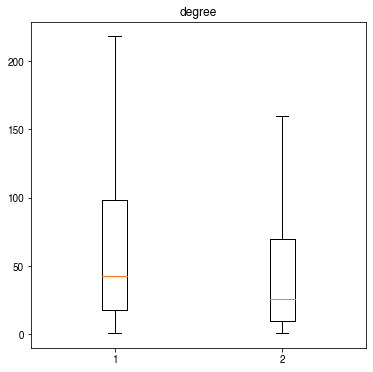

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
var = 'degree'
print('core:', len(dftc))
print('n-core:', len(dftn))
bp = ax.boxplot([dftc[var], dftn[var]], showfliers=False)
ax.set_title(var)

<AxesSubplot:xlabel='eigenvector-centrality', ylabel='pagerank'>

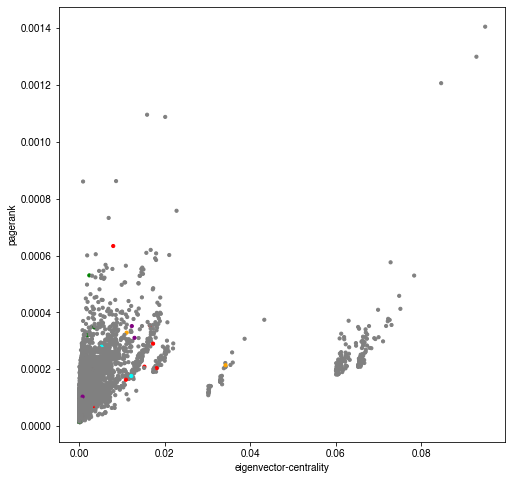

In [31]:
c = df['phenotype'].map({'A': 'red', 'B': 'blue', 'C':'green', 'D':'purple', 'E': 'cyan', 'F':'magenta', np.nan:'gray', 'G':'orange', 'H': 'darkgreen'})
df.plot(x='eigenvector-centrality', y='pagerank', kind='scatter', c=c, s=10, figsize=(8,8))

In [32]:
df['phenotype'] = df['phenotype'].fillna(0)
df.loc[df.isnull().any(axis=1), :]

,id_string,label,TPM,biotype,logFPKM,layer,conserved,module-1,module-2,module-3,module-4,module-5,module-6,module-7,module-8,core,Cyte_vs_Gonia,Tid_vs_Cyte,logFC_CyteGonia,logFC_TidCyte,phenotype,degree,degree-weight,degree-centrality,eigenvector-centrality,pagerank,avg-neighbor-degree


# ML

In [37]:
display(df)
#
logFCcols = ['logFC_MiddleApical', 'logFC_BasalMiddle'] if species == 'DM' else ['logFC_CyteGonia', 'logFC_TidCyte']
cellcompcols = ['Middle_vs_Apical', 'Middle_vs_Basal'] if species == 'DM' else ['Cyte_vs_Gonia', 'Tid_vs_Cyte']
#
num_cols = logFCcols + ['degree', 'degree-weight', 'degree-centrality', 'eigenvector-centrality', 'pagerank', 'avg-neighbor-degree'] #, 'betweenness-centrality']
bin_cols = ['conserved'] + cellcompcols + modcols
cat_cols = ['biotype']
#
cat_features = df[cat_cols].fillna(0).T.to_dict().values()
num_features = df[num_cols].values
bin_features = df[bin_cols]
#
DV = sklearn.feature_extraction.DictVectorizer(sparse=False)
SS = sklearn.preprocessing.StandardScaler()
MMS = sklearn.preprocessing.MinMaxScaler()
#
X_cat = DV.fit_transform(cat_features)
X_num = MMS.fit_transform(num_features)
X_bin = bin_features
#
features = DV.feature_names_ + num_cols + bin_cols
print(features)
#
X = np.hstack((X_cat, X_num, X_bin))
y = df['phenotype'].fillna(0).astype(bool).values
#y = df['logFC_CyteGonia'].apply(lambda x: True if x > 1 else False).values

,id_string,label,TPM,biotype,logFPKM,layer,conserved,module-1,module-2,module-3,module-4,module-5,module-6,module-7,module-8,core,Cyte_vs_Gonia,Tid_vs_Cyte,logFC_CyteGonia,logFC_TidCyte,phenotype,degree,degree-weight,degree-centrality,eigenvector-centrality,pagerank,avg-neighbor-degree
ENSMUSG00000030314,10090.ENSMUSP00000032457,Atg7,25.803287,protein_coding,4.045829,MM,True,1,0,0,0,0,0,0,0,False,True,True,2.741542,0.309248,0,309,261.417,0.027979,0.061287,0.000325,231.889058
ENSMUSG00000041477,10090.ENSMUSP00000108397,Dcp1b,49.673246,protein_coding,4.947984,MM,True,0,0,0,0,0,0,0,0,False,True,True,3.800404,0.361232,0,46,33.049,0.004165,0.000371,0.000086,94.469122
ENSMUSG00000046718,10090.ENSMUSP00000051921,Bst2,3.427752,protein_coding,1.614579,MM,False,0,0,0,0,0,0,0,0,False,True,False,-1.916914,0.000000,0,57,45.073,0.005161,0.000498,0.000106,93.230426
ENSMUSG00000054619,10090.ENSMUSP00000065271,Mettl7a1,3.749352,protein_coding,1.702770,MM,False,0,0,0,0,0,0,0,0,False,True,False,-0.583079,0.000000,0,38,33.069,0.003441,0.000084,0.000082,88.670658
ENSMUSG00000034947,10090.ENSMUSP00000045832,Tmem106a,11.042693,protein_coding,2.933503,MM,False,0,0,0,0,0,0,0,0,False,True,True,1.898434,0.021285,0,4,2.216,0.000362,0.000002,0.000021,30.412455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000029385,10090.ENSMUSP00000031331,Ccng2,3.190131,protein_coding,1.545496,MM,True,0,0,0,0,0,0,0,0,False,True,True,-1.937802,0.480737,0,50,29.429,0.004527,0.002854,0.000053,243.044616
ENSMUSG00000000552,10090.ENSMUSP00000130176,Zfp385a,53.575176,protein_coding,5.053292,MM,False,0,0,0,0,0,0,0,0,False,True,True,4.341560,0.010303,0,10,6.141,0.000905,0.000106,0.000040,153.275362
ENSMUSG00000026640,10090.ENSMUSP00000027952,Plxna2,4.934617,protein_coding,1.988488,MM,True,0,0,0,0,0,0,0,0,False,True,True,0.628930,0.110540,0,24,18.863,0.002173,0.000154,0.000069,113.993744
ENSMUSG00000044968,10090.ENSMUSP00000054458,Napepld,36.571734,protein_coding,4.523511,MM,False,0,0,0,0,0,0,0,0,False,True,True,4.263885,-0.524037,0,15,11.024,0.001358,0.000243,0.000047,56.341437


['biotype=lncRNA', 'biotype=polymorphic_pseudogene', 'biotype=processed_pseudogene', 'biotype=protein_coding', 'biotype=transcribed_processed_pseudogene', 'biotype=transcribed_unitary_pseudogene', 'biotype=transcribed_unprocessed_pseudogene', 'biotype=unprocessed_pseudogene', 'logFC_CyteGonia', 'logFC_TidCyte', 'degree', 'degree-weight', 'degree-centrality', 'eigenvector-centrality', 'pagerank', 'avg-neighbor-degree', 'conserved', 'Cyte_vs_Gonia', 'Tid_vs_Cyte', 'module-1', 'module-2', 'module-3', 'module-4', 'module-5', 'module-6', 'module-7', 'module-8']


In [38]:
random_state = 123
classifiers = OrderedDict([
    ('Uniform Dummy', DummyClassifier(strategy='uniform', random_state=random_state)),
    ('Biased Dummy', DummyClassifier(strategy='stratified', random_state=random_state)),
    ('Linear SVM', LinearSVC(max_iter=10000)),
    #('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=500)),
])

In [39]:
    # Classifier
    print('-- Fitting --')
    r = list()
    t = list()
    f = list()

    random_state = 123
    fold = 1
    for idx_train, idx_test in StratifiedKFold(n_splits=4, random_state=random_state, shuffle=True).split(X, y):
        print('Split Fold: {fold:d}'.format(fold=fold))
        X_train, y_train, X_test, y_test = X[idx_train], y[idx_train], X[idx_test], y[idx_test]
        for clf_name, clf in classifiers.items():
            print('Fitting: {clf_name:s}'.format(clf_name=clf_name))

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            if hasattr(clf, 'predict_proba'):
                probas_pred = clf.predict_proba(X_test)[:, 1]
            else:
                probas_pred = clf.decision_function(X_test)
                # probas_pred = (probas_pred - probas_pred.min()) / (probas_pred.max() - probas_pred.min())

            precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred, pos_label=1)
            fprs, tprs, thresholds = roc_curve(y_test, probas_pred, pos_label=1)

            pr_auc = auc(recalls, precisions)
            roc_auc = auc(fprs, tprs)
            if 'Dummy' not in clf_name:
                # To CSV
                for y_test_, probas_pred_ in zip(y_test, probas_pred):
                    t.append((clf_name, fold, y_test_, probas_pred_))

            # Eval
            precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
            mcc = matthews_corrcoef(y_test, y_pred)
            TN, FP, FN, TP = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

            # Features
            if hasattr(clf, 'coef_'):
                coefs = clf.coef_ if len(clf.coef_) > 1 else clf.coef_[0]
                for feature, coef in zip(features, coefs):
                    f.append((clf_name, fold, feature, coef))

            # Results
            r.append((clf_name, fold, TP, TN, FP, FN, precision, recall, f1, support, mcc, roc_auc, pr_auc))
        fold += 1

-- Fitting --
Split Fold: 1
Fitting: Uniform Dummy
Fitting: Biased Dummy
Fitting: Linear SVM
Fitting: Logistic Regression
Split Fold: 2
Fitting: Uniform Dummy
Fitting: Biased Dummy


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/anaconda3/lib/pytho

Fitting: Linear SVM
Fitting: Logistic Regression
Split Fold: 3
Fitting: Uniform Dummy
Fitting: Biased Dummy
Fitting: Linear SVM
Fitting: Logistic Regression
Split Fold: 4
Fitting: Uniform Dummy
Fitting: Biased Dummy
Fitting: Linear SVM
Fitting: Logistic Regression


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/anaconda3/lib/pytho

In [40]:
print('> AUC Thresholds')
dfT = pd.DataFrame(t, columns=['clf', 'fold', 'y_test', 'probas'])
display(dfT)
#wMLTFile = 'results/ml/ml_thresholds_{layer:s}-SVD-{col:s}.csv.gz'.format(layer=layer, col=col)
#dfT.to_csv(wMLTFile, encoding='utf-8', index=False)

print('> Features')
dfF = pd.DataFrame(f, columns=['clf', 'fold', 'feature', 'coef'])
dfF = dfF.groupby(['clf', 'feature']).agg({'coef': 'mean'})
display(dfF)
#wMLFFile = 'results/ml/ml_features_{layer:s}-SVD-{col:s}.csv.gz'.format(layer=layer, col=col)
#dfF.to_csv(wMLFFile, encoding='utf-8', index=True)

print('> Classification')
dfR = pd.DataFrame(r, columns=['clf', 'fold', 'TP', 'TN', 'FP', 'FN', 'precision', 'recall', 'f1', 'support', 'mcc', 'roc_auc', 'pr_auc'])
dfR.sort_values('clf', inplace=True)
dfR.groupby('clf').agg('sum')
display(dfR)
#wMLCFile = 'results/ml/ml_clfs_{layer:s}-SVD-{col:s}.csv.gz'.format(layer=layer, col=col)
#dfR.to_csv(wMLCFile, encoding='utf-8', index=False)
#print(dfR.groupby('clf').agg('mean'))

> AUC Thresholds


,clf,fold,y_test,probas
0,Linear SVM,1,False,-1.304592
1,Linear SVM,1,False,-1.177136
2,Linear SVM,1,False,-1.197084
3,Linear SVM,1,False,-1.289712
4,Linear SVM,1,False,-1.284986
...,...,...,...,...
22085,Logistic Regression,4,False,0.000984
22086,Logistic Regression,4,False,0.006613
22087,Logistic Regression,4,False,0.001072
22088,Logistic Regression,4,False,0.003050


> Features


coef
clf                 feature                                             
Linear SVM          Cyte_vs_Gonia                              -0.062822
                    Tid_vs_Cyte                                 0.060150
                    avg-neighbor-degree                        -0.017380
                    biotype=lncRNA                             -0.201532
                    biotype=polymorphic_pseudogene             -0.149962
                    biotype=processed_pseudogene               -0.208721
                    biotype=protein_coding                     -0.201518
                    biotype=transcribed_processed_pseudogene   -0.149828
                    biotype=transcribed_unitary_pseudogene     -0.079649
                    biotype=transcribed_unprocessed_pseudogene -0.009963
                    biotype=unprocessed_pseudogene             -0.100850
                    conserved                                   0.226616
                    degree                                      0.062474
                    degree-centrality                           0.062474
                    degree-weight                              -0.208854
                    eigenvector-centrality                      0.288478
                    logFC_CyteGonia                             0.551851
                    logFC_TidCyte                              -0.318930
                    module-1                                   -0.242205
                    module-2                                   -0.169759
                    module-3                                   -0.220869
                    module-4                                   -0.018400
                    module-5                                    0.046143
                    module-6                                   -0.105471
                    module-7                                    0.052653
                    module-8                                   -0.070048
                    pagerank                                    0.350125
Logistic Regression Cyte_vs_Gonia                              -0.373537
                    Tid_vs_Cyte                                -0.050926
                    avg-neighbor-degree                        -0.735634
                    biotype=lncRNA                             -0.233359
                    biotype=polymorphic_pseudogene             -0.101805
                    biotype=processed_pseudogene               -1.043238
                    biotype=protein_coding                     -1.967981
                    biotype=transcribed_processed_pseudogene   -0.188636
                    biotype=transcribed_unitary_pseudogene     -0.035379
                    biotype=transcribed_unprocessed_pseudogene -0.024575
                    biotype=unprocessed_pseudogene             -0.072317
                    conserved                                   2.069344
                    degree                                      0.302936
                    degree-centrality                           0.302936
                    degree-weight                               0.192162
                    eigenvector-centrality                      0.048176
                    logFC_CyteGonia                             3.235219
                    logFC_TidCyte                              -3.309995
                    module-1                                   -0.296038
                    module-2                                   -0.667929
                    module-3                                   -0.983954
                    module-4                                   -0.067919
                    module-5                                    0.782899
                    module-6                                   -0.249097
                    module-7                                    1.086013
                    module-8                                   -0.224235
                    pagerank                         

> Classification


,clf,fold,TP,TN,FP,FN,precision,recall,f1,support,mcc,roc_auc,pr_auc
1,Biased Dummy,1,0,2724,20,18,0.000000,0.000000,0.000000,None,-0.006917,0.496356,0.003259
5,Biased Dummy,2,1,2725,19,16,0.050000,0.058824,0.054054,None,0.047875,0.525950,0.057309
9,Biased Dummy,3,0,2724,20,17,0.000000,0.000000,0.000000,None,-0.006723,0.496356,0.003079
13,Biased Dummy,4,0,2724,20,17,0.000000,0.000000,0.000000,None,-0.006723,0.496356,0.003079
2,Linear SVM,1,0,2744,0,18,0.000000,0.000000,0.000000,None,0.000000,0.912152,0.198989
6,Linear SVM,2,0,2744,0,17,0.000000,0.000000,0.000000,None,0.000000,0.893522,0.038424
10,Linear SVM,3,0,2744,0,17,0.000000,0.000000,0.000000,None,0.000000,0.886597,0.084136
14,Linear SVM,4,0,2744,0,17,0.000000,0.000000,0.000000,None,0.000000,0.877144,0.065710
3,Logistic Regression,1,0,2744,0,18,0.000000,0.000000,0.000000,None,0.000000,0.906948,0.078708
7,Logistic Regression,2,0,2744,0,17,0.000000,0.000000,0.000000,None,0.000000,0.887584,0.030223


In [86]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
#isomap = manifold.Isomap(n_neighbors=5, n_components=2)
X_manifold = tsne.fit_transform(X)

In [87]:
X_manifold

array([[-12.914741, -75.18693 ],
       [  9.668035, -78.24841 ],
       [-39.936687,  38.600445],
       ...,
       [ 53.772926, -36.932724],
       [  9.685013,  83.17764 ],
       [-10.879934,  19.861645]], dtype=float32)

[]

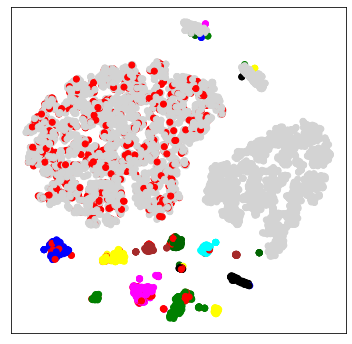

In [88]:
#x_min, x_max = np.min(X, 0), np.max(X, 0)
#X = (X - x_min) / (x_max - x_min)

fig, ax = plt.subplots(figsize=(6,6), nrows=1, ncols=1)

# Set color
#c = df['core'].map({True: 'red', False: 'blue'})
def modcolor(r):
    if r['core'] == True:
        return 'red'
    if r['module-1'] == True:
        return 'magenta'
    if r['module-2'] == True:
        return 'blue'
    if r['module-3'] == True:
        return 'green'
    if r['module-4'] == True:
        return 'cyan'
    if r['module-5'] == True:
        return 'brown'
    if r['module-6'] == True:
        return 'yellow'
    if r['module-11'] == True:
        return 'darkgreen'
    if r['module-12'] == True:
        return 'black'
    return 'lightgray'

c = df.apply(modcolor, axis=1)
#
ax.scatter(X_manifold[:,0], X_manifold[:,1], c=c)

ax.set_xticks([])
ax.set_yticks([])

In [50]:
dftc = df.loc[df['core']==True, :]
dftn = df.loc[df['core']!=True, :]

<AxesSubplot:ylabel='Frequency'>

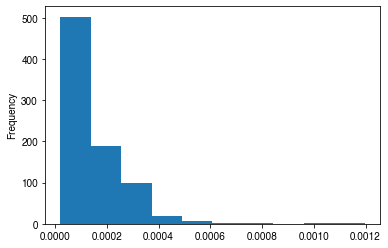

In [42]:
dftc['pagerank'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

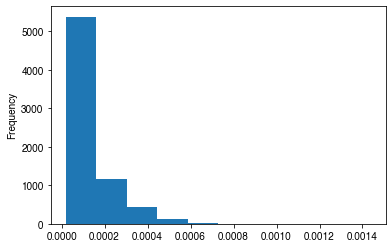

In [43]:
dftn['pagerank'].plot.hist()